In [1]:
import numpy as np
from matplotlib import pyplot as plt
from dsapol import dsapol
from scipy.signal import correlate
from scipy.signal import savgol_filter as sf
from scipy.signal import convolve
from scipy.signal import fftconvolve
from scipy.ndimage import convolve1d
from scipy.signal import peak_widths
from scipy.stats import chi
from scipy.stats import norm
import panel as pn
pn.extension()
#from numpy.ma import masked_array as ma
import numpy.ma as ma
from scipy.stats import kstest
from scipy.optimize import curve_fit
import time
#import numpy.ma as ma 
%load_ext autoreload
%autoreload 2 

from scipy.signal import find_peaks
from scipy.signal import peak_widths
import copy
import numpy as np
import os
import param

from sigpyproc import FilReader
from sigpyproc.Filterbank import FilterbankBlock
from sigpyproc.Header import Header
from matplotlib import pyplot as plt
import pylab
import pickle
import json
from scipy.interpolate import interp1d
from scipy.stats import chi2
from scipy.stats import chi
from scipy.signal import savgol_filter as sf
from scipy.signal import convolve
from scipy.ndimage import convolve1d
from RMtools_1D.do_RMsynth_1D import run_rmsynth
from RMtools_1D.do_RMclean_1D import run_rmclean
from RMtools_1D.do_QUfit_1D_mnest import run_qufit

plt.rcParams.update({
                    'font.size': 16,
                    'font.family': 'serif',
                    'axes.labelsize': 16,
                    'axes.titlesize': 16,
                    'xtick.labelsize': 12,
                    'ytick.labelsize': 12,
                    'xtick.direction': 'in',
                    'ytick.direction': 'in',
                    'xtick.top': True,
                    'ytick.right': True,
                    'lines.linewidth': 1,
                    'lines.markersize': 5,
                    'legend.fontsize': 14,
                    'legend.borderaxespad': 0,
                    'legend.frameon': False,
                    'legend.loc': 'lower right'})


from astropy.time import Time
from astropy.coordinates import EarthLocation
import astropy.units as u


def gauss_scint(x,bw,amp,off):
    return off + amp*np.exp(-np.log(2)*((x/bw)**2))


def lorentz_scint(x,bw,amp,off):
    return off + amp*(bw/(x**2 + (0.5*bw**2)))

fsize=30
fsize2=20
plt.rcParams.update({
                    'font.size': fsize,
                    'font.family': 'sans-serif',
                    'axes.labelsize': fsize,
                    'axes.titlesize': fsize,
                    'xtick.labelsize': fsize,
                    'ytick.labelsize': fsize,
                    'xtick.direction': 'in',
                    'ytick.direction': 'in',
                    'xtick.top': True,
                    'ytick.right': True,
                    'lines.linewidth': 1,
                    'lines.markersize': 5,
                    'legend.fontsize': fsize2,
                    'legend.borderaxespad': 0,
                    'legend.frameon': False,
                    'legend.loc': 'lower right'})

In [2]:
from pol_panel_funcs import pol_plot
from pol_panel_funcs import pol_panel
from pol_panel_funcs import RM_plot
from pol_panel_funcs import RM_panel


In [3]:
"""
def fit_parabola(x,a,b,c):
    return -a*((x-c)**2) + b

#New significance estimate
def L_sigma(Q,U,timestart,timestop,plot=False,weighted=False,I_w_t_filt=None):


    L0_t = np.sqrt(np.mean(Q,axis=0)**2 + np.mean(U,axis=0)**2)
    
    if weighted:
        L0_t_w = L0_t*I_w_t_filt
        L_trial_binned = convolve(L0_t,I_w_t_filt)
        sigbin = np.argmax(L_trial_binned)
        noise = np.std(np.concatenate([L_trial_binned[:sigbin],L_trial_binned[sigbin+1:]]))
        print("weighted: " + str(noise))

    else:
        L_trial_cut1 = L0_t[timestart%(timestop-timestart):]
        L_trial_cut = L_trial_cut1[:(len(L_trial_cut1)-(len(L_trial_cut1)%(timestop-timestart)))]
        L_trial_binned = L_trial_cut.reshape(len(L_trial_cut)//(timestop-timestart),timestop-timestart).mean(1)
        sigbin = np.argmax(L_trial_binned)
        noise = (np.std(np.concatenate([L_trial_cut[:sigbin],L_trial_cut[sigbin+1:]])))
        print("not weighted: " + str(noise))
    return noise

def RM_plot(RMsnrs,trial_RM,RMsnrstools,trial_RM_tools,RMsnrszoom,trial_RMzoom,init_RM,fine_RM):
    fig = plt.figure(figsize=(20,24))
    ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 0),colspan=2)
    ax2 = plt.subplot2grid(shape=(2, 2), loc=(1, 0),colspan=2)
    ax2_1 = ax2.twinx()
    
    ax1.set_xlabel(r'RM ($rad/m^2$)')
    ax1.set_ylabel(r'F($\phi$)')
    ax2.set_xlabel(r'RM ($rad/m^2$)')
    ax2.set_ylabel(r'S/N')
    ax2_1.set_ylabel(r'F($\phi$)')
    
    
    #INITIAL SYNTHESIS
    ax1.plot(trial_RM,RMsnrs,label="RM synthesis",color="black")
    ax1.plot(trial_RM_tools,RMsnrstools,alpha=0.5,label="RM Tools",color="blue")
    ax1.legend(loc="upper right")
    
    
    #FINE SYNTHESIS
    if fine_RM:
        ax2_1.plot(trial_RMzoom,RMsnrszoom,label="RM synthesis",color="black")
        ax2_1.legend(loc="upper right")
    return fig
    
    

class RM_panel(param.Parameterized):
    
    error = param.String(default="",label="output/errors")
    I = np.zeros((20480,6144))
    Q = np.zeros((20480,6144))
    U = np.zeros((20480,6144))
    V = np.zeros((20480,6144))
    
    I_f = np.nan*np.ones(6144)
    Q_f = np.nan*np.ones(6144)
    U_f = np.nan*np.ones(6144)
    V_f = np.nan*np.ones(6144)
    
    freq_test_init = [np.zeros(6144)]*4
    n_t = 1
    curr_weights = np.nan*np.ones(20480)
    timestart = -1
    timestop = -1
    
    
    #***Initial RM synthesis + Rm tools***#
    init_RM = True
    fine_RM = False
    trial_RM = np.linspace(-1e6,1e6,1000)
    trial_RM_tools = copy.deepcopy(trial_RM)
    trial_phi = [0]
    RM1 = param.String(default="",label=r'Initial RM (rad/m^2)')
    RMerr1 = param.String(default="",label=r'error (rad/m^2)')
    RM1tools = param.String(default="",label=r'Initial RM-Tools RM (rad/m^2)')
    RMerr1tools = param.String(default="",label=r'error (rad/m^2)')
    RMsnrs1 = np.nan*np.ones(len(trial_RM))
    RMsnrs1tools = np.nan*np.ones(np.min([len(trial_RM),int(1e4)]))
    RMmin = param.String(default="-1000000",label=r'Minimum Trial RM (rad/m^2)')
    RMmax = param.String(default="1000000",label=r'Maximum Trial RM (rad/m^2)')
    numRMtrials = param.String(default="1000",label=r'Number of Trial RMs')

    
    #***Fine RM synthesis + RM tools + S/N method***#
    numRMtrials_zoom = param.String(default="5000",label=r'Number of Trial RMs (Fine)')
    zoom_window = param.String(default="1000",label=r'RM range above/below initial result (rad/m^2)')
    trial_RM2 = np.linspace(0-1000,0+1000,5000)
    RMsnrs1zoom = np.nan*np.ones(len(trial_RM2))
    RM1zoom = param.String(default="",label=r'Final RM Synthesis (rad/m^2)')
    RMerr1zoom = param.String(default="",label=r'error (rad/m^2)')
    
    def clicked_run(self):
        try:
            if self.init_RM:
                self.error = "Running initial RM synthesis..."
                t1 = time.time()
                self.trial_RM = np.linspace(float(self.RMmin),float(self.RMmax),int(self.numRMtrials))
                RM1,phi1,self.RMsnrs1,RMerr1 = dsapol.faradaycal(self.I_f,self.Q_f,self.U_f,self.V_f,self.freq_test,self.trial_RM,self.trial_phi,plot=False,show=False,fit_window=100,err=True)
                self.RM1 = str(np.around(RM1,2))
                self.RMerr1 = str(np.around(RMerr1,2))
                
                self.error = "Running initial RM tools..."
                #trial_RM_tools = np.linspace(-1e6,1e6,int(1e4))
                
                
                n_off = int(12000/self.n_t)


                Ierr = np.std(self.I[:,:n_off],axis=1)
                Ierr[Ierr.mask] = np.nan
                Ierr = Ierr.data

                Qerr = np.std(self.Q[:,:n_off],axis=1)
                Qerr[Qerr.mask] = np.nan
                Qerr = Qerr.data

                Uerr = np.std(self.U[:,:n_off],axis=1)
                Uerr[Uerr.mask] = np.nan
                Uerr = Uerr.data

                I_fcal_rmtools = self.I_f.data
                I_fcal_rmtools[self.I_f.mask] = np.nan

                Q_fcal_rmtools = self.Q_f.data
                Q_fcal_rmtools[self.Q_f.mask] = np.nan

                U_fcal_rmtools = self.U_f.data
                U_fcal_rmtools[self.U_f.mask] = np.nan

                if len(self.trial_RM) <= 1e4:
                    self.trial_RM_tools = copy.deepcopy(self.trial_RM)
                else:
                    self.error = "Using maximum 1e4 trials for RM tools..."
                    self.trial_RM_tools = np.linspace(np.min(self.trial_RM),np.max(self.trial_RM),int(1e4))
                out=run_rmsynth([self.freq_test[0]*1e6,I_fcal_rmtools,Q_fcal_rmtools,U_fcal_rmtools,Ierr,Qerr,Uerr],phiMax_radm2=np.max(self.trial_RM_tools),dPhi_radm2=np.abs(self.trial_RM_tools[1]-self.trial_RM_tools[0]))

                self.error = "RM Cleaning..."
                out=run_rmclean(out[0],out[1],2) 

                self.trial_RM_tools = out[1]["phiArr_radm2"]
                self.RMsnrs1tools = np.abs(out[1]["cleanFDF"])
                self.RM1tools = str(np.around(out[0]["phiPeakPIchan_rm2"],2))
                self.RMerr1tools = str(np.around(out[0]["dPhiPeakPIchan_rm2"],2))
                
                 
                self.error = "Complete: " + str(np.around(time.time()-t1,2)) + " s to run initial RM synthesis"
                
                self.init_RM = False
                self.fine_RM = True
            else:
                self.error = "Running fine RM synthesis..."
                t1 = time.time()
                
                self.trial_RM2 = np.linspace(float(self.RM1)-float(self.zoom_window),float(self.RM1)+float(self.zoom_window),int(self.numRMtrials_zoom))

                tmpRM1zoom,phi1zoom,self.RMsnrs1zoom,tmpRMerr1zoom = dsapol.faradaycal(self.I_f,self.Q_f,self.U_f,self.V_f,self.freq_test,self.trial_RM2,self.trial_phi,plot=False,show=False,fit_window=100,err=True)

                fit_window=50
                oversamps = 5000
                poptpar,pcovpar = curve_fit(fit_parabola,self.trial_RM2[np.argmax(self.RMsnrs1zoom)-fit_window:np.argmax(self.RMsnrs1zoom)+fit_window],self.RMsnrs1zoom[np.argmax(self.RMsnrs1zoom)-fit_window:np.argmax(self.RMsnrs1zoom)+fit_window],p0=[1,1,float(self.RM1)],sigma=1/self.RMsnrs1zoom[np.argmax(self.RMsnrs1zoom)-fit_window:np.argmax(self.RMsnrs1zoom)+fit_window])
                FWHMRM1zoom,tmp,tmp,tmp = peak_widths(self.RMsnrs1zoom,[np.argmax(self.RMsnrs1zoom)])
                noisezoom = L_sigma(self.Q,self.U,self.timestart,self.timestop,plot=False,weighted=True,I_w_t_filt=self.curr_weights)
                self.RM1zoom = str(np.around(poptpar[2],2))
                self.RMerr1zoom = str(np.around(FWHMRM1zoom[0]*(self.trial_RM2[1]-self.trial_RM2[0])*noisezoom/(2*np.max(self.RMsnrs1zoom)),2))

                
                
                self.error = "Running fine RM tools..."
                
                self.error = "Running fine S/N method..."
                
                
                self.error = "Complete: " + str(np.around(time.time()-t1,2)) + " s to run fine RM synthesis"
                
        except Exception as e:
            self.error = "From clicked_run(): " + str(e)
        return
        
    run = param.Action(clicked_run,label="Run")
    
    
    
    #***VIEWING MODULE***#
    def view(self):
        try:
            #update trial RM
            self.trial_RM = np.linspace(float(self.RMmin),float(self.RMmax),int(self.numRMtrials))
            
            return RM_plot(self.RMsnrs1,self.trial_RM,self.RMsnrs1tools,self.trial_RM_tools,self.RMsnrs1zoom,self.trial_RM2,self.init_RM,self.fine_RM)
        except Exception as e:
            self.error = "From view(): " + str(e)
            return
"""

'\ndef fit_parabola(x,a,b,c):\n    return -a*((x-c)**2) + b\n\n#New significance estimate\ndef L_sigma(Q,U,timestart,timestop,plot=False,weighted=False,I_w_t_filt=None):\n\n\n    L0_t = np.sqrt(np.mean(Q,axis=0)**2 + np.mean(U,axis=0)**2)\n    \n    if weighted:\n        L0_t_w = L0_t*I_w_t_filt\n        L_trial_binned = convolve(L0_t,I_w_t_filt)\n        sigbin = np.argmax(L_trial_binned)\n        noise = np.std(np.concatenate([L_trial_binned[:sigbin],L_trial_binned[sigbin+1:]]))\n        print("weighted: " + str(noise))\n\n    else:\n        L_trial_cut1 = L0_t[timestart%(timestop-timestart):]\n        L_trial_cut = L_trial_cut1[:(len(L_trial_cut1)-(len(L_trial_cut1)%(timestop-timestart)))]\n        L_trial_binned = L_trial_cut.reshape(len(L_trial_cut)//(timestop-timestart),timestop-timestart).mean(1)\n        sigbin = np.argmax(L_trial_binned)\n        noise = (np.std(np.concatenate([L_trial_cut[:sigbin],L_trial_cut[sigbin+1:]])))\n        print("not weighted: " + str(noise))\n    r

# Try again, implementing based on Casey's Template

In [4]:



def build_pol_tab():
    
    
    
    # make dropdown box to choose FRB file
    x=os.listdir("/media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us") 
    FRB_list = []
    for i in range(len(x)):
        if len(x[i]) >= 10 and x[i][10] == "_":
            FRB_list.append(x[i])

    
    
    #(I_t_init,Q_t_init,U_t_init,V_t_init) = dsapol.get_stokes_vs_time(I,Q,U,V,1,fobj.header.tsamp,n_t,n_off=int(12000//n_t),plot=True,show=True,normalize=True,buff=1,window=30)
    menu_calplots = pn.widgets.MenuButton(name="Select FRB to Load",
                                          items=FRB_list,
                                         width=200)
    
    load_button = pn.widgets.Button(name='Load FRB', width=100, button_type='primary')
    
    # make dropdown box to choose calibration file
    y = os.listdir("/media/ubuntu/ssd/sherman/code")
    CAL_list = []
    
    for i in range(len(y)):
        if ("POLCAL_PARAMETERS" in y[i]) and ("csv" in y[i]):
            CAL_list.append(y[i])
    calmenu_calplots = pn.widgets.MenuButton(name="Select Calibration File to Load",
                                      items=CAL_list,
                                     width=200)
    
    cal_button = pn.widgets.Button(name='Calibrate', width=100, button_type='primary')
    ibeam_input = pn.widgets.IntSlider(name='ibeam', start=0, end=250, step=1, value=0)
    RA_input = pn.widgets.FloatInput(name='RA (degrees)', value=0, step=1e-2, start=0, end=360)
    DEC_input = pn.widgets.FloatInput(name='DEC (degrees)', value=0, step=1e-2, start=-90, end=90)
    
    def callback(target, event):
        target.error = "Loading FRB..."
        #target.frb_submitted = True

    def callback_cal(target,event):
        target.error = "Calibrating FRB..."
        
    pane_test = pn.pane.Markdown('# DSA-110 Polarization Dashboard')
    pan1 = pol_panel()
    
    menu_calplots.link(pan1, clicked='frb_name')
    load_button.link(pan1,callbacks={'clicks': callback})#pan1, clicks='frb_submitted')
    
    calmenu_calplots.link(pan1,clicked='cal_name')
    cal_button.link(pan1,callbacks={'clicks': callback_cal})#pan1, clicks='frb_submitted')
    ibeam_input.link(pan1,value='ibeam')
    RA_input.link(pan1,value='RA')
    DEC_input.link(pan1,value='DEC')
    
    pan2 = RM_panel()
    #link IQUV from panel1 to panel 2
    def callback_link(target,event):
        target.error = "Transferring data between panels..."
        t1 = time.time()
        target.I = pan1.I
        target.Q = pan1.Q
        target.U = pan1.U
        target.V = pan1.V
        
        target.I_f = pan1.I_f_init
        target.Q_f = pan1.Q_f_init
        target.U_f = pan1.U_f_init
        target.V_f = pan1.V_f_init
        
        target.freq_test = pan1.freq_test_init
        target.n_t = pan1.n_t
        target.n_f = pan1.n_f
        target.curr_weights = pan1.curr_weights
        target.timestart = pan1.timestart
        target.timestop = pan1.timestop
        target.ibox = pan1.ibox
        target.fobj = pan1.fobj
        target.comp_dict = pan1.comp_dict
        
        target.error = "Complete: " + str(np.around(time.time()-t1,2)) + " s to transfer data"
    link_button = pn.widgets.Button(name='Proceed to RM Synthesis',width=200,button_type='primary')
    link_button.link(pan2,callbacks={'clicks': callback_link})#pan1, clicks='frb_submitted')
    
    
    return pn.Column(pane_test,pn.Row(menu_calplots,load_button,calmenu_calplots,ibeam_input,RA_input,DEC_input,cal_button,link_button),pn.Row(pan1.param,pan1.view,pan2.param,pan2.view))


#ADD JAKOB'S CODE HERE FOR BURSTFIT TAB
def burstfit_tab():
    pass
    

In [5]:
pol_pane = pn.param.ParamFunction(build_pol_tab,lazy=True)


In [6]:
dashboard = pn.Column(pn.Row(pn.layout.tabs.Tabs(('Polarization', pol_pane),
                                                 #('Burstfit',burstfit_tab),
                                                dynamic=True, active=0),
                             margin=(10, 10, 10, 10), background='#f0f0f0'))

/media/ubuntu/ssd/sherman/code/pol_panel_funcs.py:120: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  faxs[i-1].set_xlim(np.min(freq_test[0]),np.max(freq_test[0]))
/media/ubuntu/ssd/sherman/code/pol_panel_funcs.py:128: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  faxs[-1].set_xlim(np.min(freq_test[0]),np.max(freq_test[0]))


Reading stokes param...0Reading Filterbank File: /media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us/220207aabh_zach/220207aabh_dev_0.fil 
Done! 
Reading stokes param...1Reading Filterbank File: /media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us/220207aabh_zach/220207aabh_dev_1.fil 
Done! 
Reading stokes param...2Reading Filterbank File: /media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us/220207aabh_zach/220207aabh_dev_2.fil 
Done! 
Reading stokes param...3Reading Filterbank File: /media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us/220207aabh_zach/220207aabh_dev_3.fil 
Done! 
Reading Filterbank File: /media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us/220207aabh_zach/220207aabh_dev_0.fil 
Reading Filterbank File: /media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us/220207aabh_zach/220207aabh_dev_1.fil 
Reading Filterbank File: /media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us/220207aabh_zach/220207aabh_dev_2.fil 
Reading Filterbank File: /media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us/220207aabh_zach/220207aabh_dev_3.fil 
Binning by 1 in time 
Binning by 16 in frequency 
Bad Channels: [] 
20480 20480 
No SF Filter 
20480 20480 
No SF Filter 
20480 20480 
No SF Filter 
20480 20480 
No SF Filter 
10240 10240 
No SF Filter 
10240 10240 
10240 10240 
10240 10240 
10240 10240 
10240 10240 
10240 10240 
10240 10240 
10240 10240 
10240 10240 
10240 10240 
10240 10240 
dict_keys(['timestart', 'timestop', 'comp_num', 'buff', 'n_t_weight', 'sf_window_weights', 'ibox', 'mask_start', 'mask_stop', 'weights', 'multipeaks', 'I_f', 'Q_f', 'U_f', 'V_f', 'I_f_init', 'Q_f_init', 'U_f_init', 'V_f_init']) 
0 
20480 20480 
(22.24375674728365, 0.3467225039715466, 64.15434963837554) 
(10.16675418049732, 0.2600022550999174, 39.10256153966931) 
(9.426768298016059, 0.2600022550999174, 36.256486676984416) 
(3.498453052343045, 0.2584579761060602, 13.53586801634409) 
10240 10240 
dict_keys(['timestart', 'timestop', 'comp_num', 'buff', 'n_t_weight', 'sf_window_weights', 'ibox', 'mask_start', 'mask_stop', 'weights', 'multipeaks', 'I_f', 'Q_f', 'U_f', 'V_f', 'I_f_init', 'Q_f_init', 'U_f_init', 'V_f_init', 'T/I_pre', 'T/I_pre_err', 'T/I_pre_snr', 'L/I_pre', 'L/I_pre_err', 'L/I_pre_snr', 'absV/I_pre', 'absV/I_pre_err', 'V/I', 'V/I_err', 'V/I_snr', 'I_snr']) 
0 
10240 10240 
dict_keys(['timestart', 'timestop', 'comp_num', 'buff', 'n_t_weight', 'sf_window_weights', 'ibox', 'mask_start', 'mask_stop', 'weights', 'multipeaks', 'I_f', 'Q_f', 'U_f', 'V_f', 'I_f_init', 'Q_f_init', 'U_f_init', 'V_f_init', 'T/I_pre', 'T/I_pre_err', 'T/I_pre_snr', 'L/I_pre', 'L/I_pre_err', 'L/I_pre_snr', 'absV/I_pre', 'absV/I_pre_err', 'V/I', 'V/I_err', 'V/I_snr', 'I_snr']) 
0 
10240 10240 
dict_keys(['timestart', 'timestop', 'comp_num', 'buff', 'n_t_weight', 'sf_window_weights', 'ibox', 'mask_start', 'mask_stop', 'weights', 'multipeaks', 'I_f', 'Q_f', 'U_f', 'V_f', 'I_f_init', 'Q_f_init', 'U_f_init', 'V_f_init', 'T/I_pre', 'T/I_pre_err', 'T/I_pre_snr', 'L/I_pre', 'L/I_pre_err', 'L/I_pre_snr', 'absV/I_pre', 'absV/I_pre_err', 'V/I', 'V/I_err', 'V/I_snr', 'I_snr']) 
0 
10240 10240 
dict_keys(['timestart', 'timestop', 'comp_num', 'buff', 'n_t_weight', 'sf_window_weights', 'ibox', 'mask_start', 'mask_stop', 'weights', 'multipeaks', 'I_f', 'Q_f', 'U_f', 'V_f', 'I_f_init', 'Q_f_init', 'U_f_init', 'V_f_init', 'T/I_pre', 'T/I_pre_err', 'T/I_pre_snr', 'L/I_pre', 'L/I_pre_err', 'L/I_pre_snr', 'absV/I_pre', 'absV/I_pre_err', 'V/I', 'V/I_err', 'V/I_snr', 'I_snr']) 
0 
10240 10240 
dict_keys(['timestart', 'timestop', 'comp_num', 'buff', 'n_t_weight', 'sf_window_weights', 'ibox', 'mask_start', 'mask_stop', 'weights', 'multipeaks', 'I_f', 'Q_f', 'U_f', 'V_f', 'I_f_init', 'Q_f_init', 'U_f_init', 'V_f_init', 'T/I_pre', 'T/I_pre_err', 'T/I_pre_snr', 'L/I_pre', 'L/I_pre_err', 'L/I_pre_snr', 'absV/I_pre', 'absV/I_pre_err', 'V/I', 'V/I_err', 'V/I_snr', 'I_snr']) 
0 
10240 10240 
dict_k

Column
    [0] Row(background='#f0f0f0', margin=(10, 10, 10, 10))
        [0] Tabs(dynamic=True)
            [0] ParamFunction(function, lazy=True)
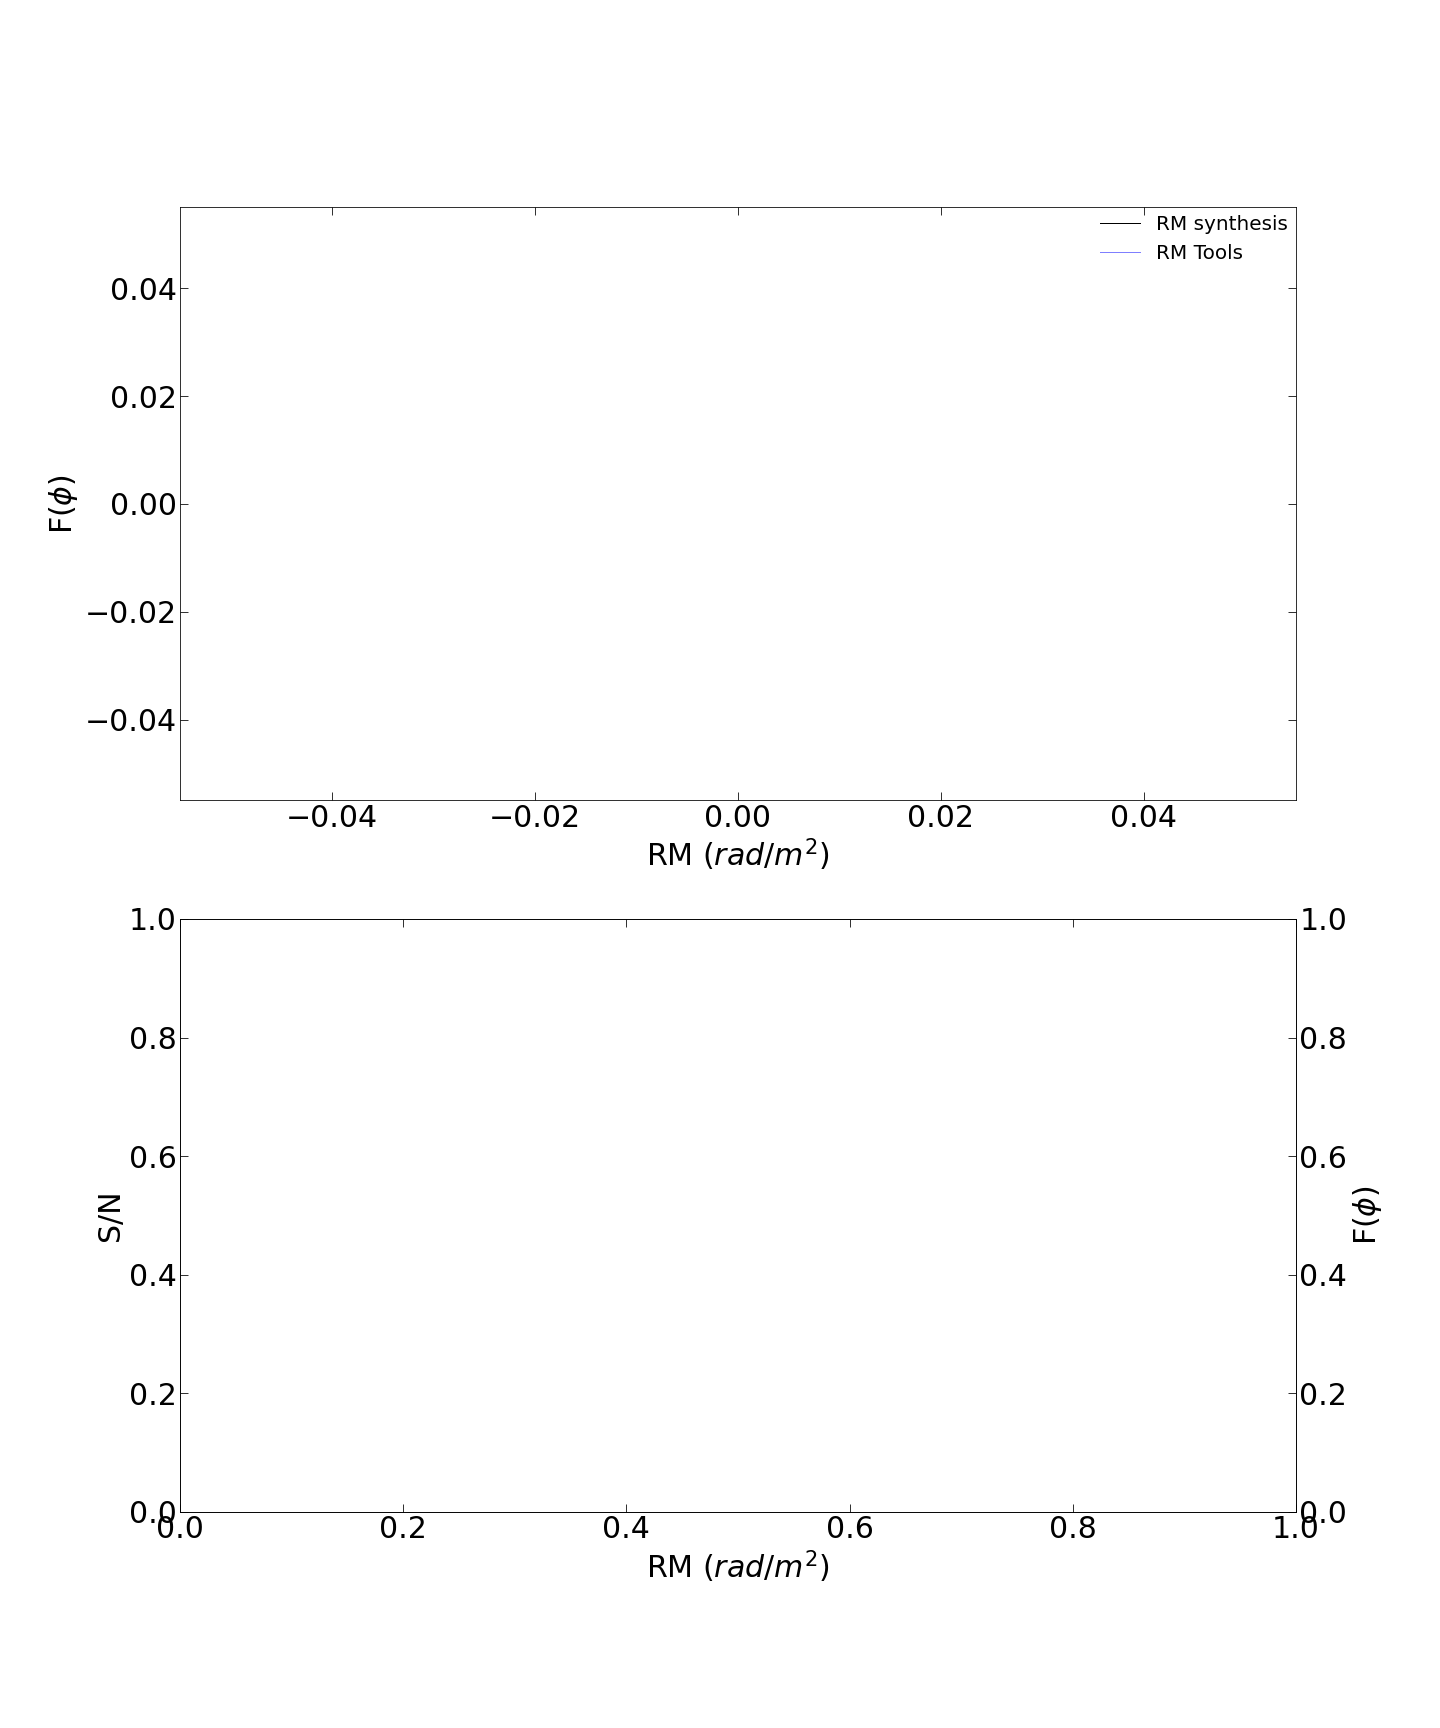
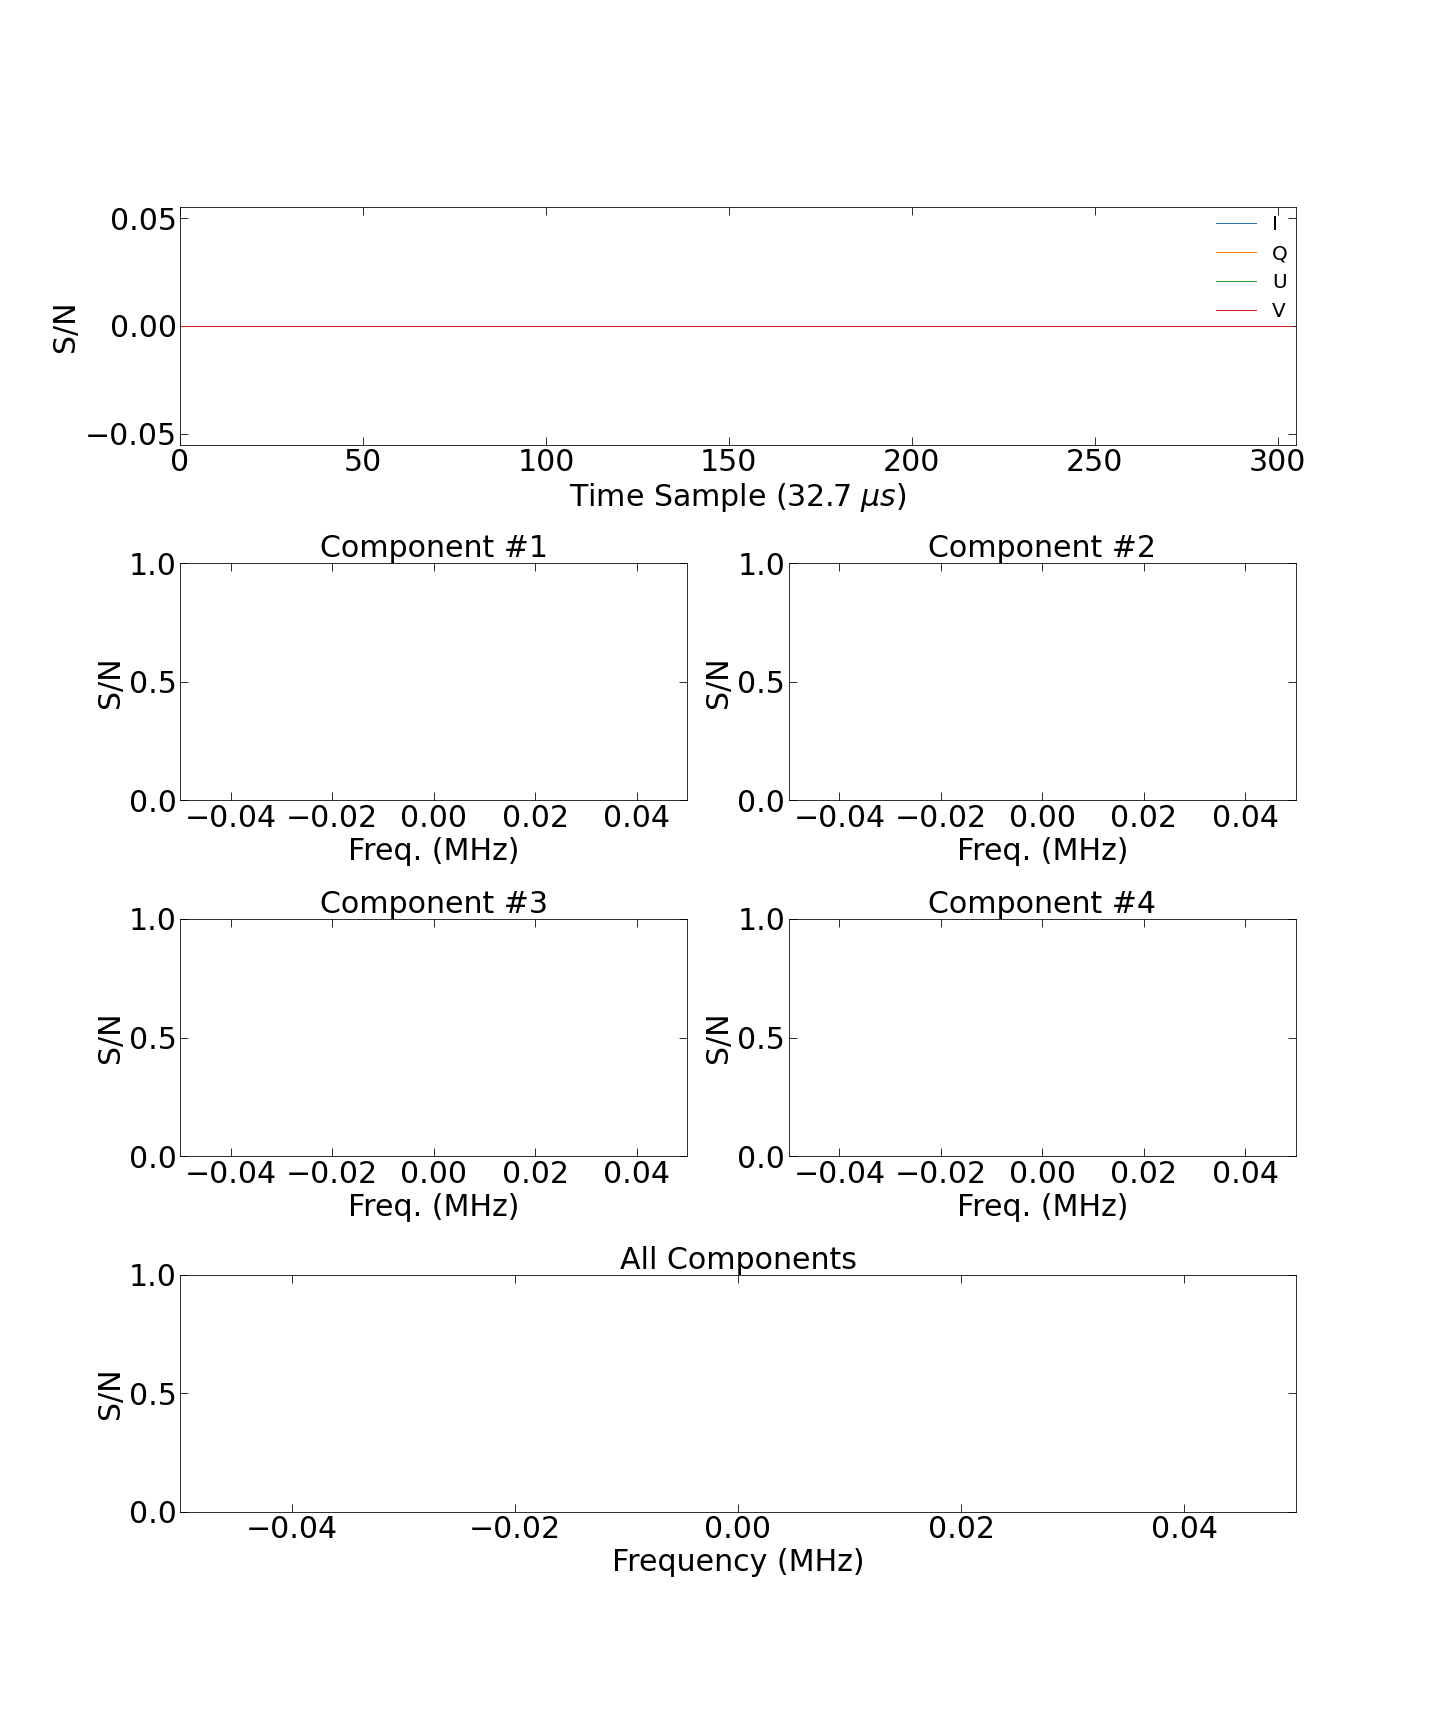

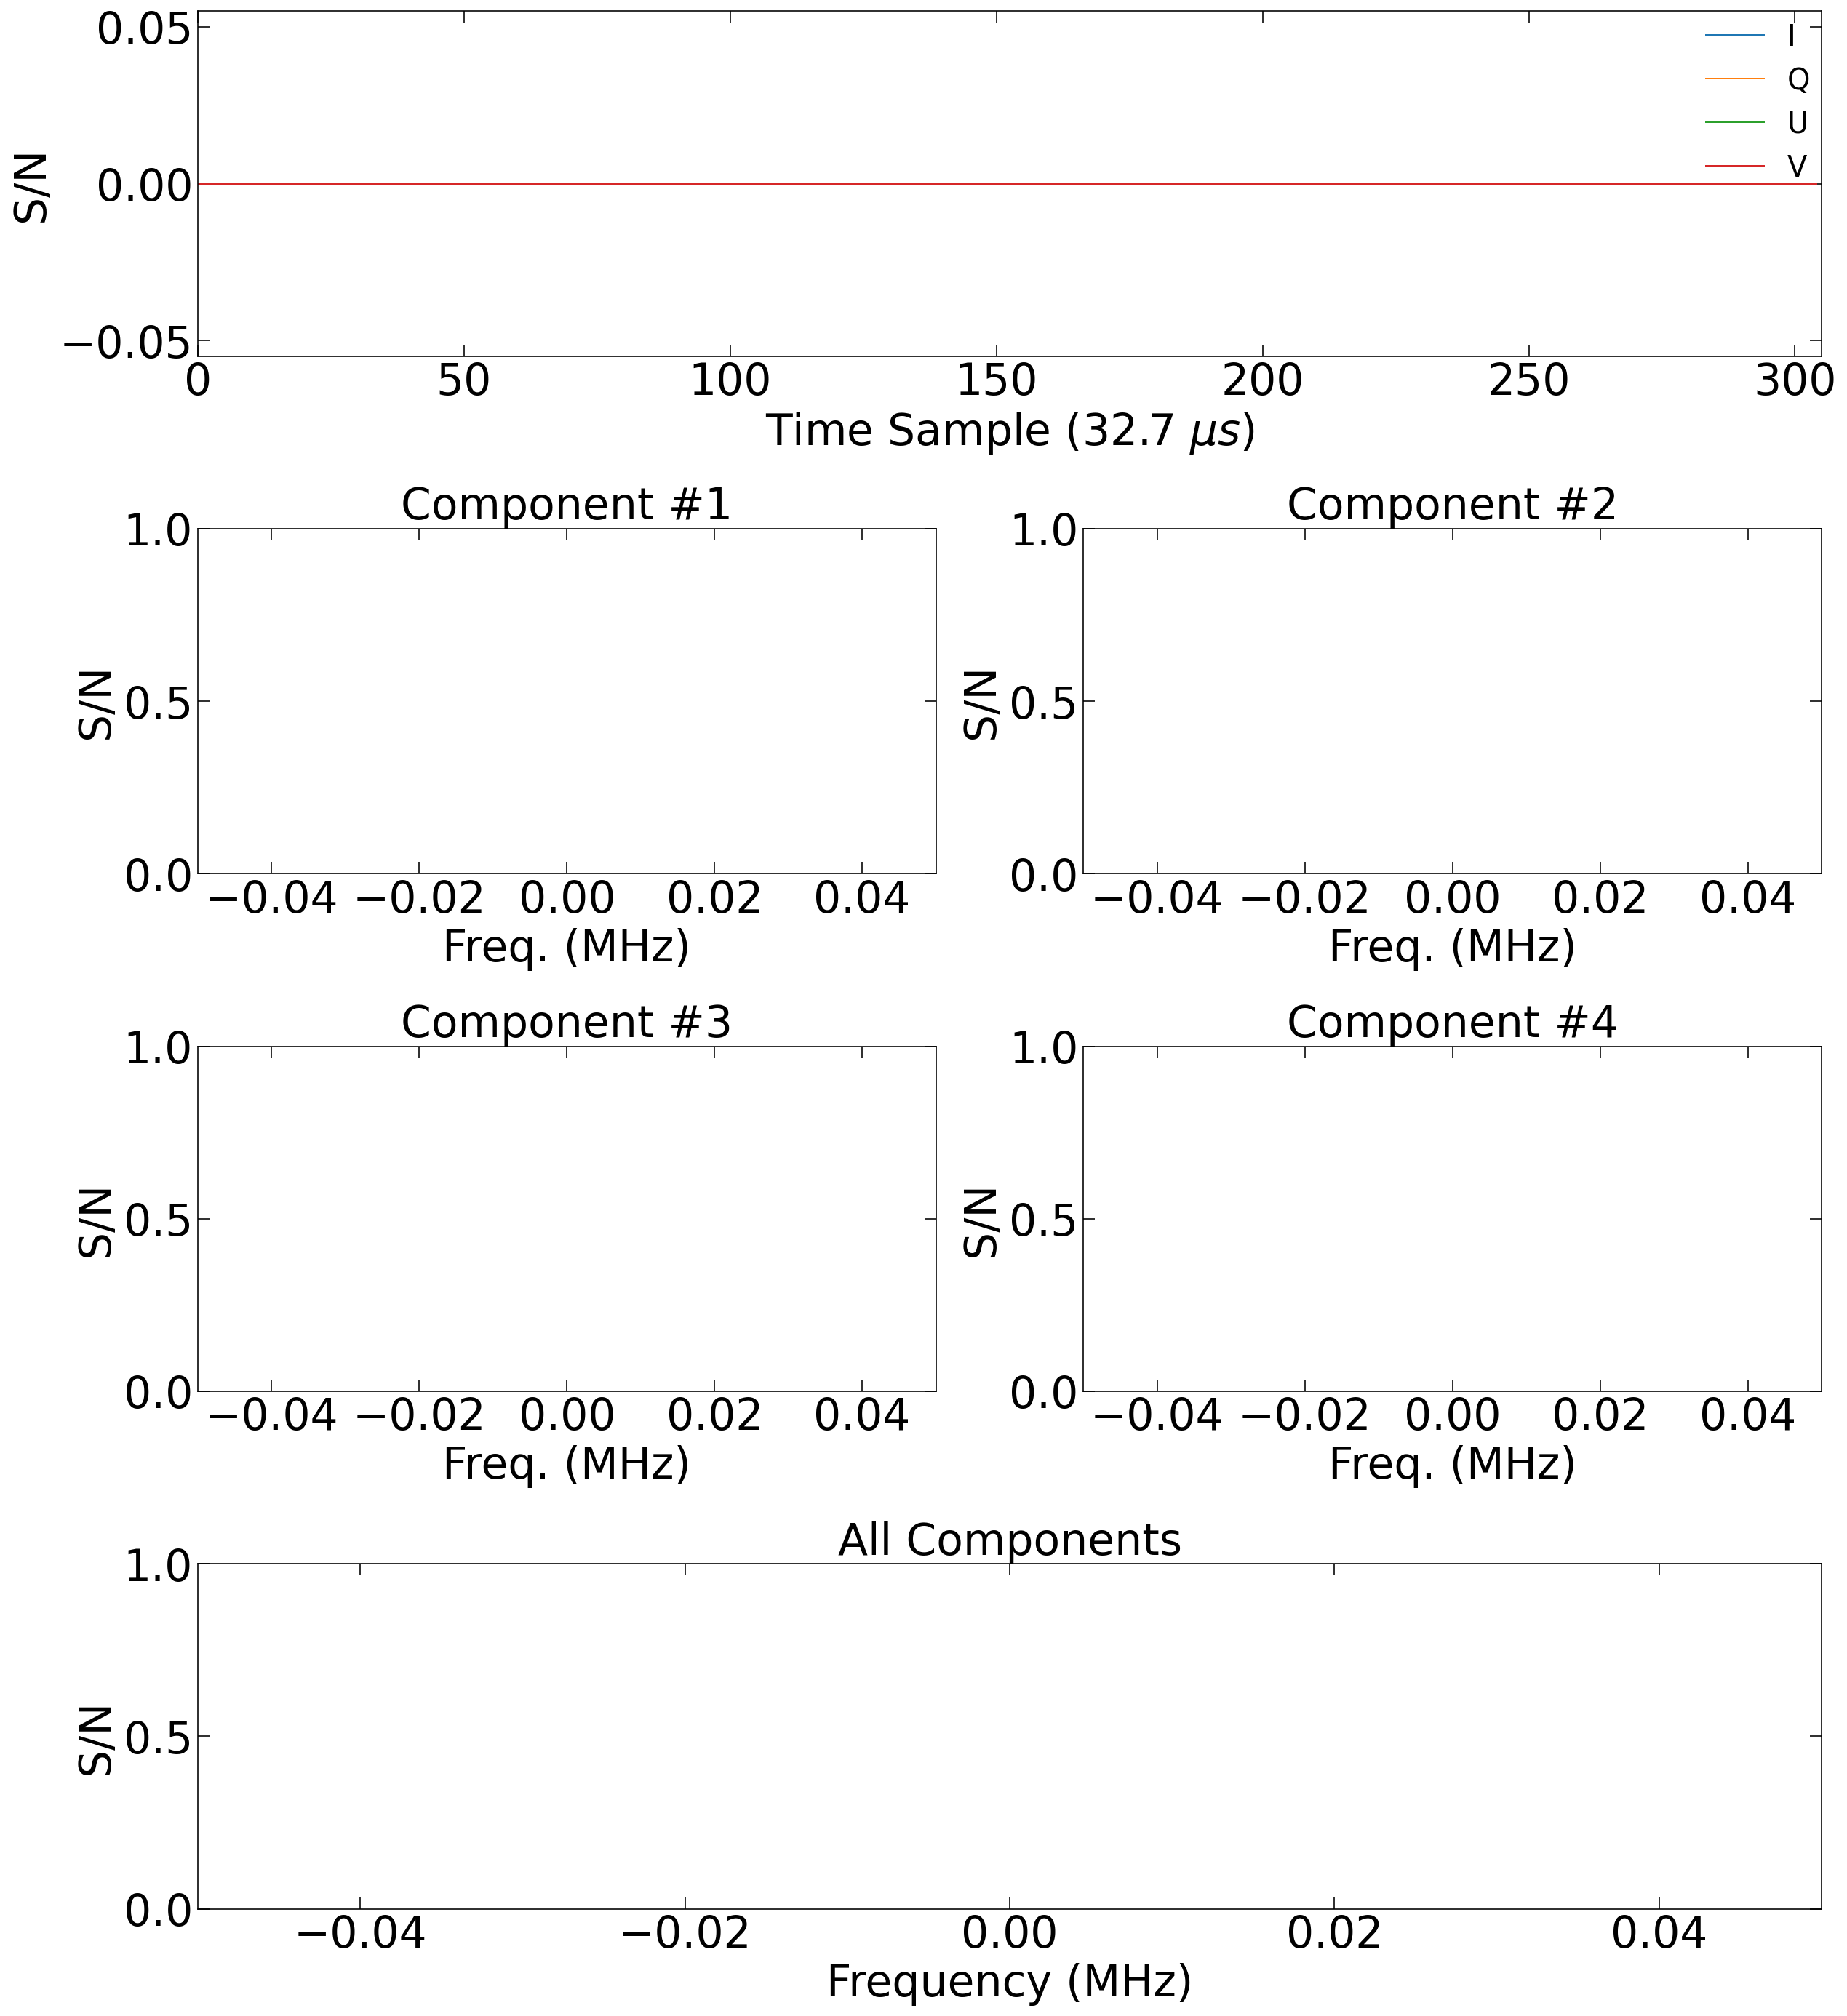

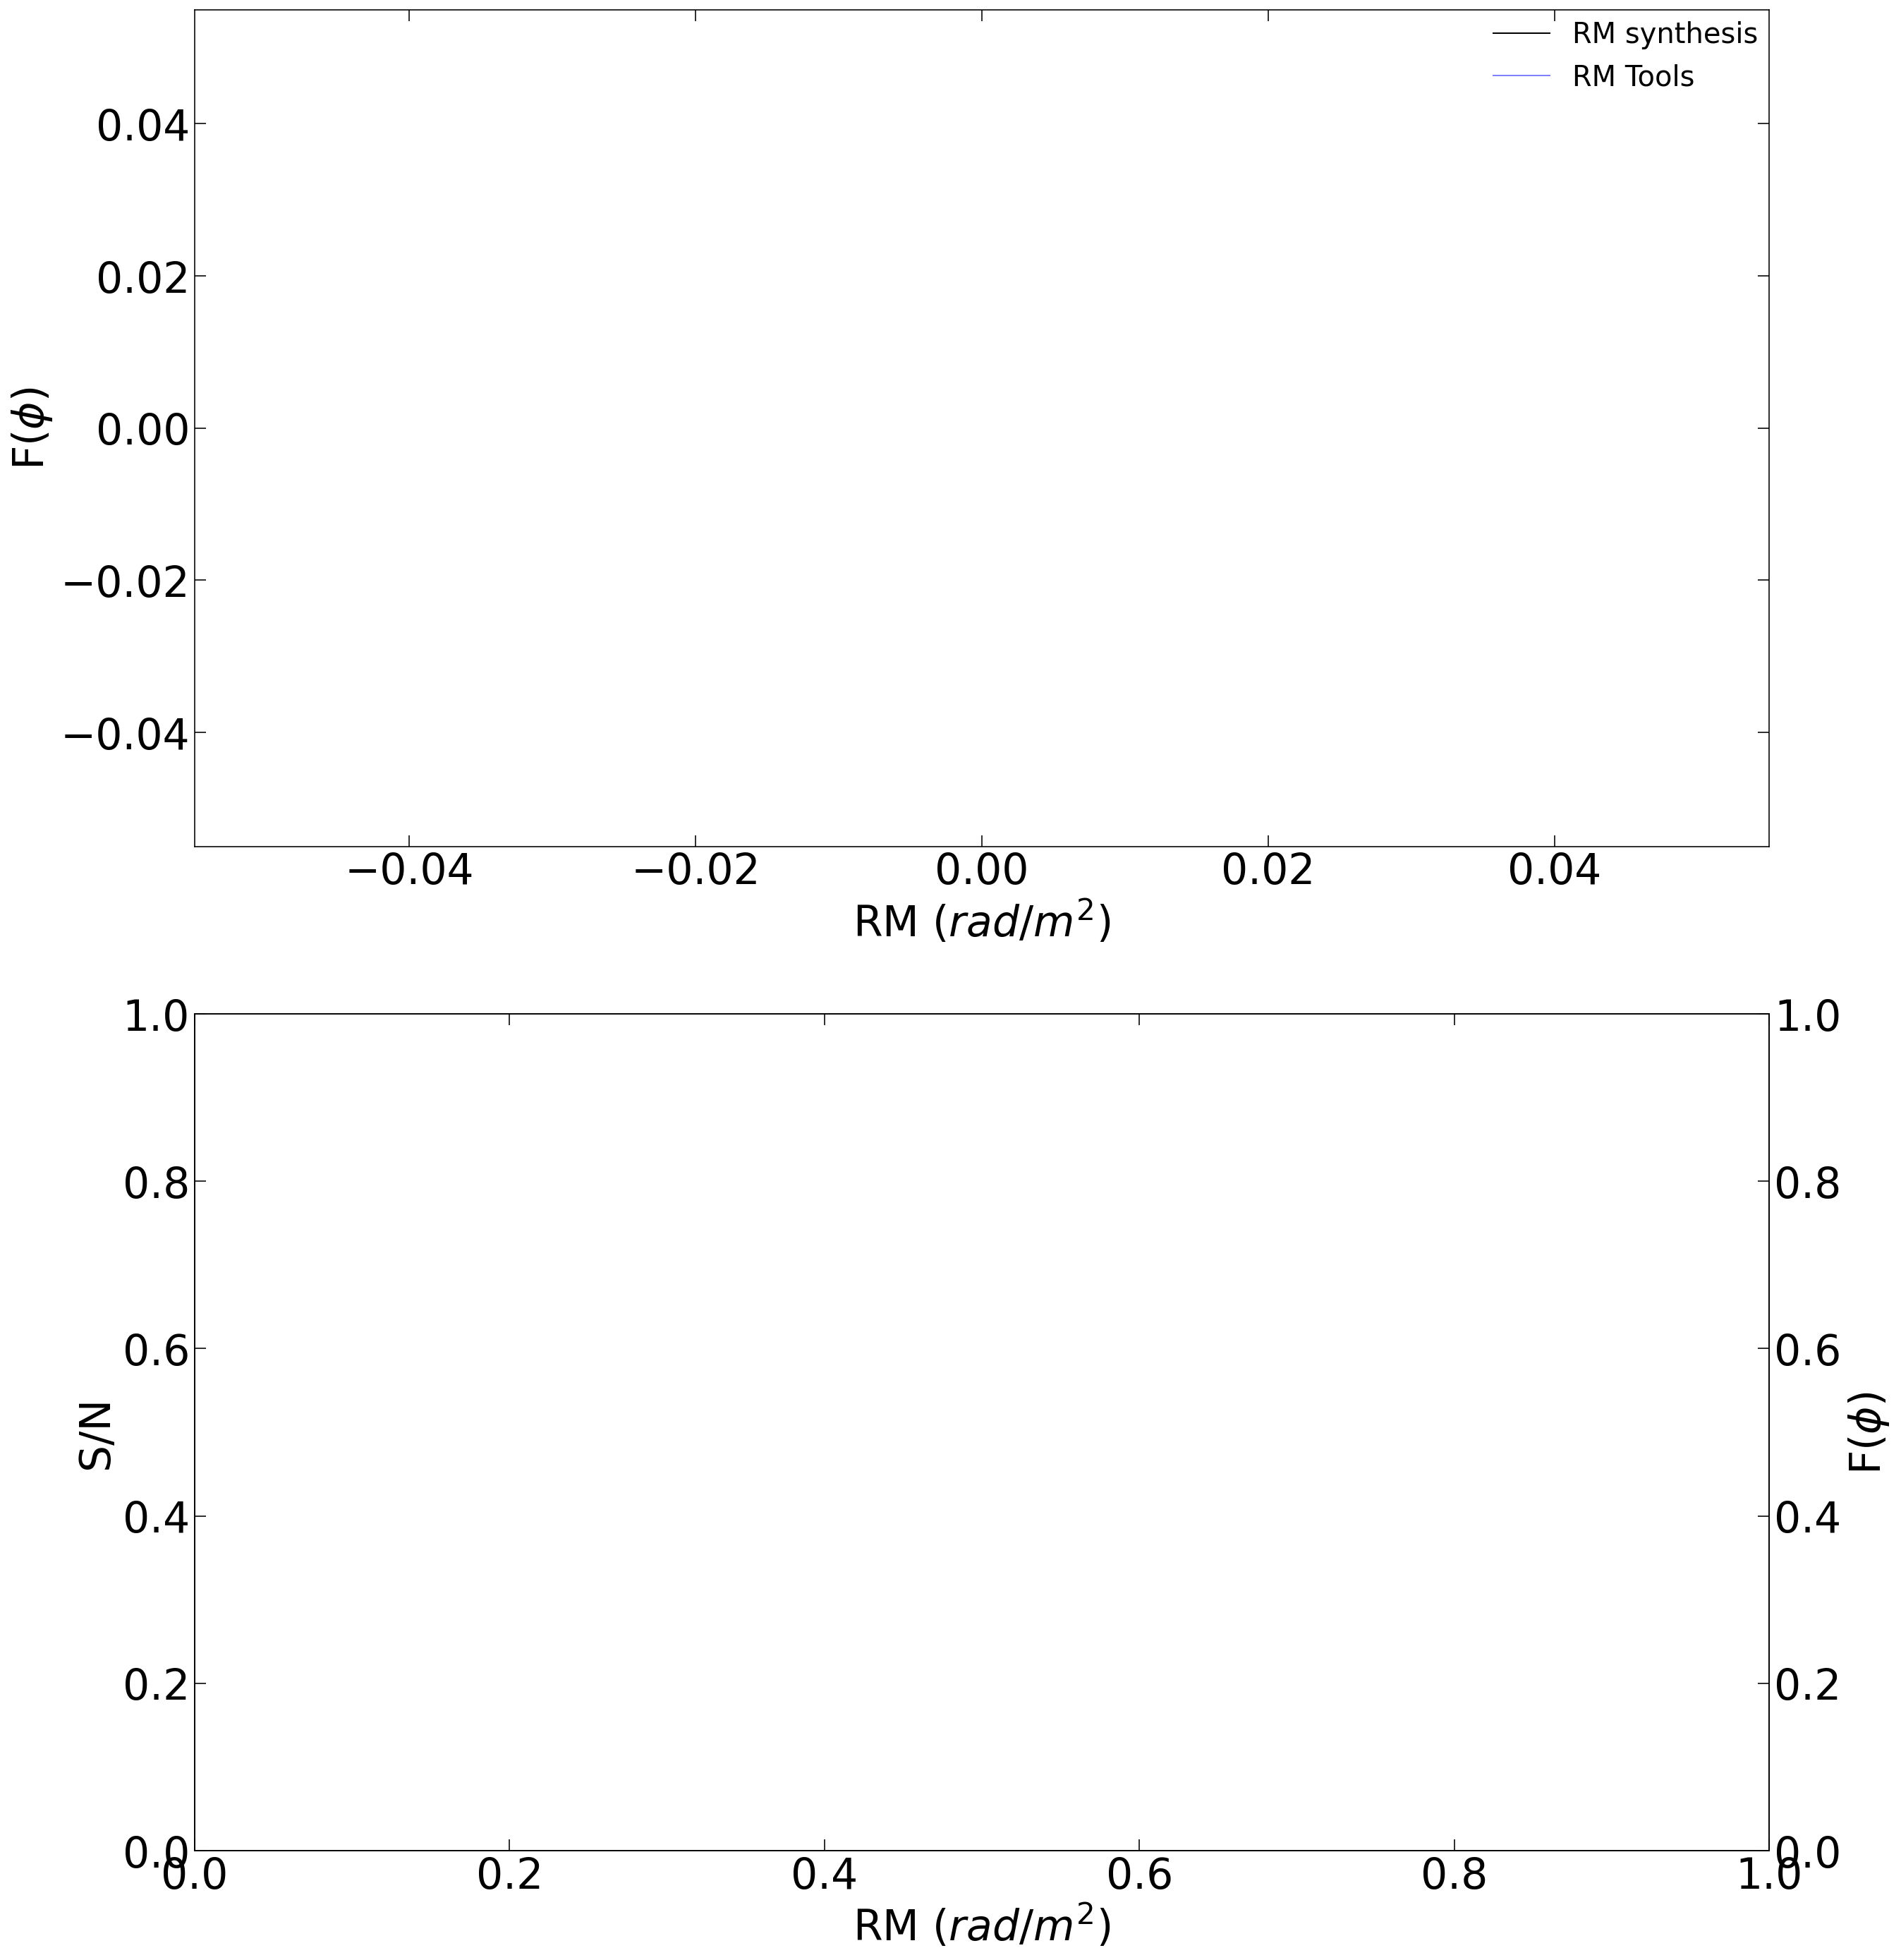

In [7]:
dashboard

Column
    [0] Row(background='#f0f0f0', margin=(10, 10, 10, 10))
        [0] Tabs(dynamic=True)
            [0] ParamFunction(function, lazy=True)
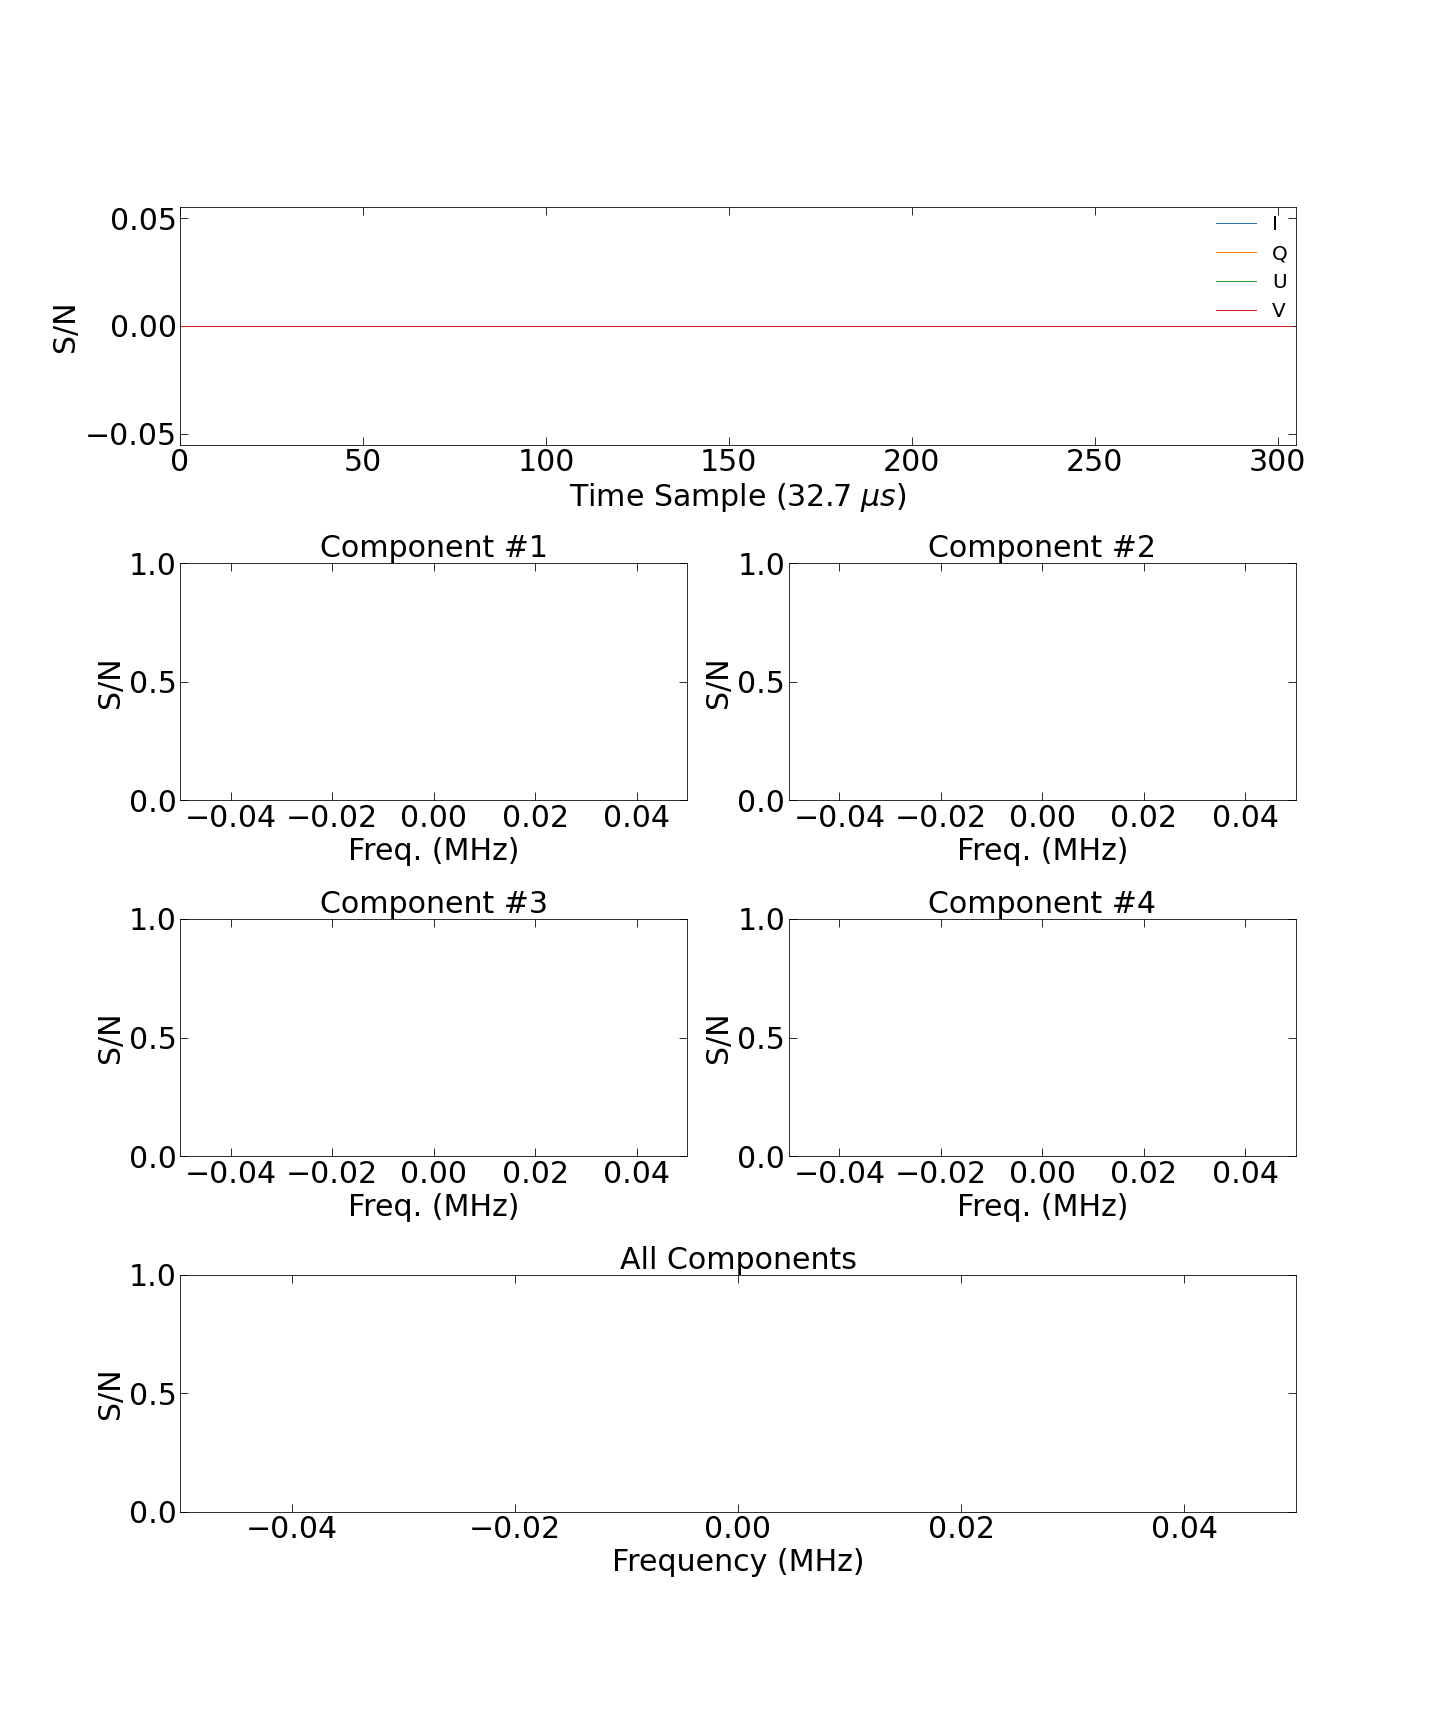
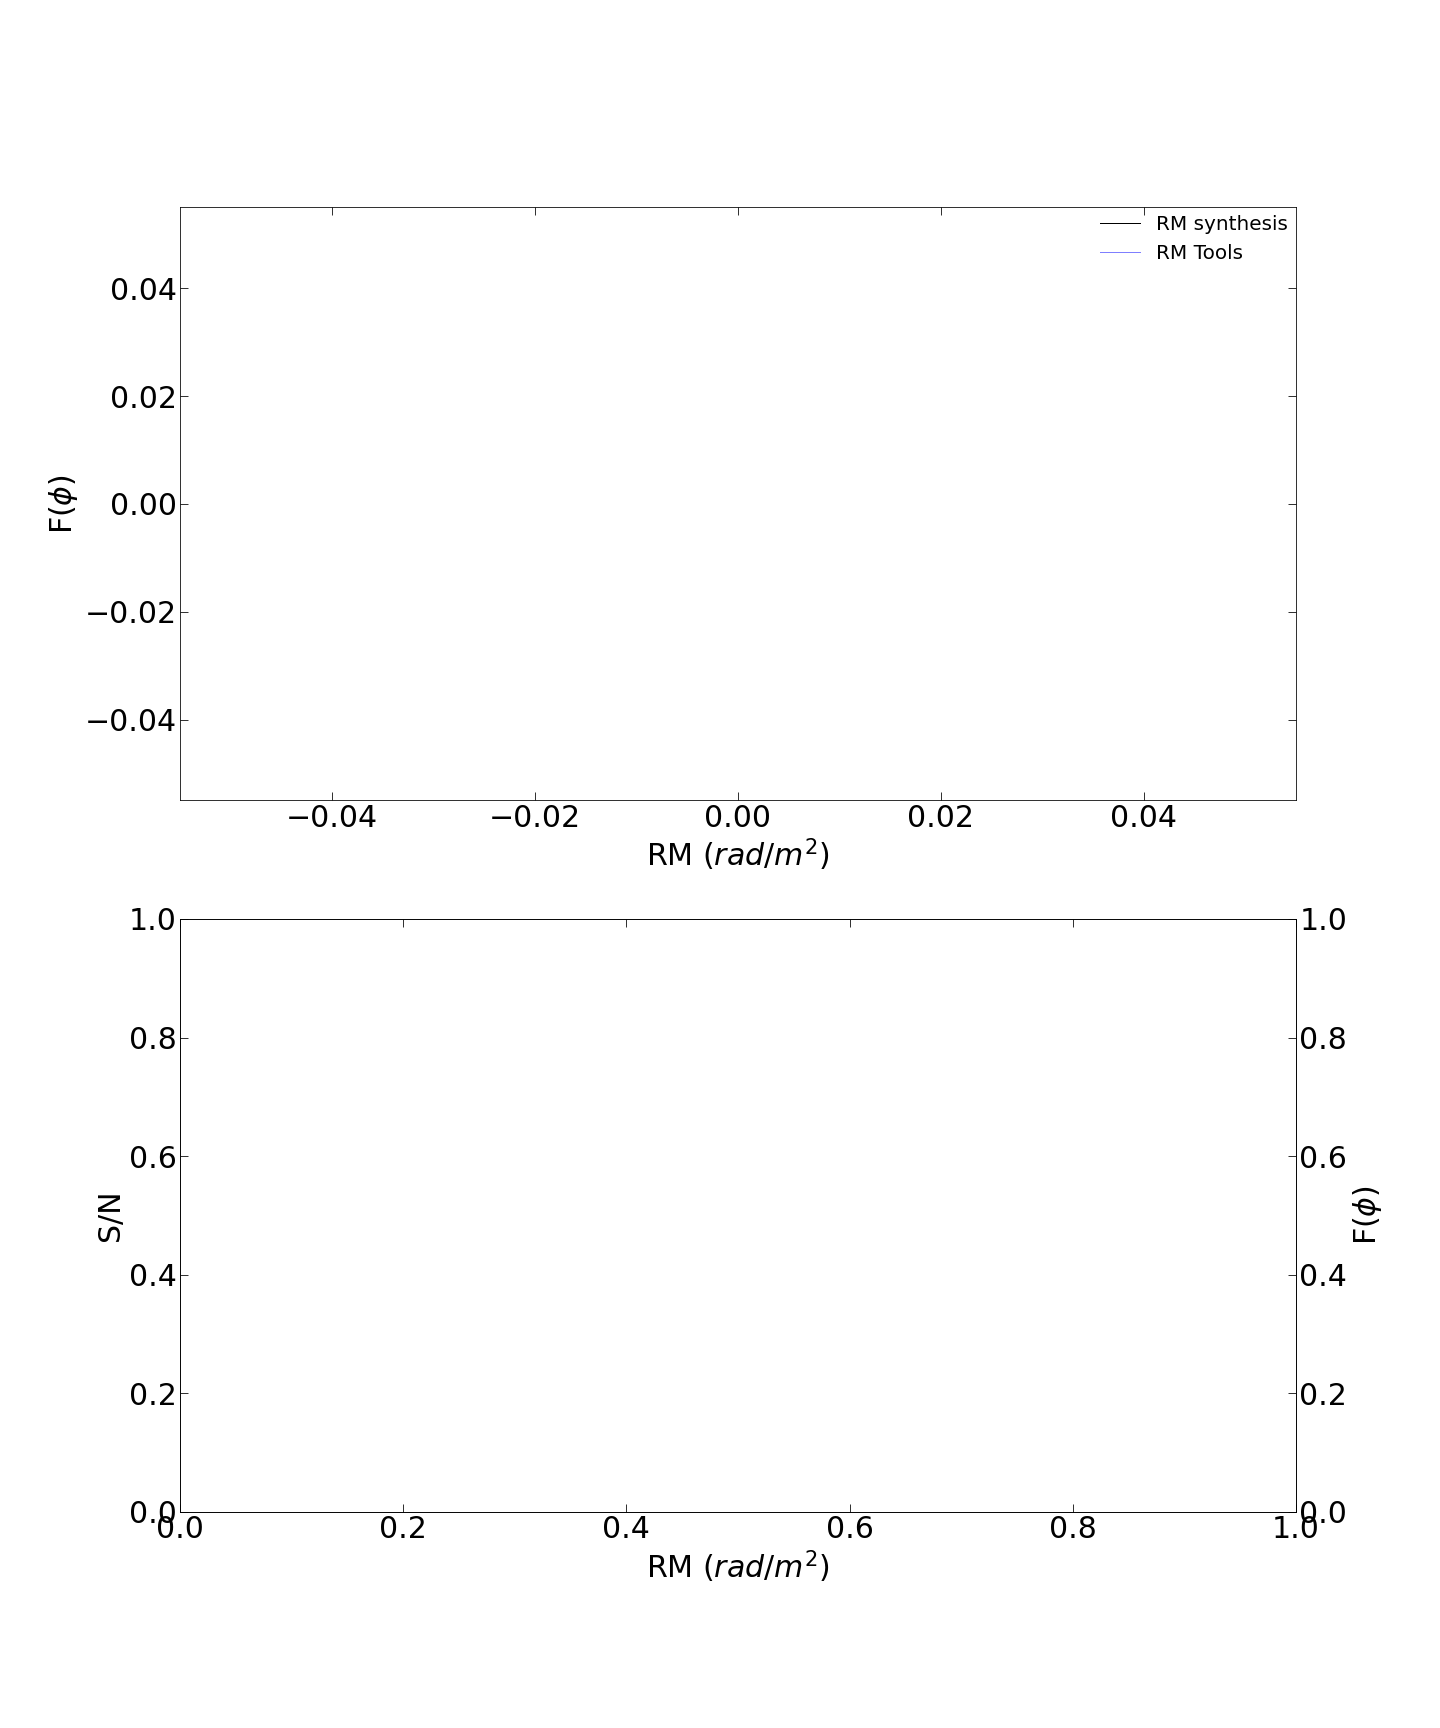

In [8]:
dashboard.servable(title="Burst Analysis Dashboard")